In [1]:
import tensorflow as tf
import keras as K

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Project4/'

images_path = [path + 'data' + i + '/' + 'CameraRGB' for i in ['A', 'B', 'C', 'D', 'E']]
masks_path = [path + 'data' + i + '/' + 'CameraSeg' for i in ['A', 'B', 'C', 'D', 'E']]

In [4]:
def return_paths(path):
  X = []

  for url in sorted(path):
    filenames = sorted(os.listdir(url))

    for filename in filenames:
      X.append(url + '/' + filename)

  return X

In [5]:
X = return_paths(images_path)
y = return_paths(masks_path)

In [6]:
len(X)

5000

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=10)

In [8]:
len(X_train)

4000

(600, 800, 3)
(600, 800, 3)


Text(0.5, 1.0, 'Mask')

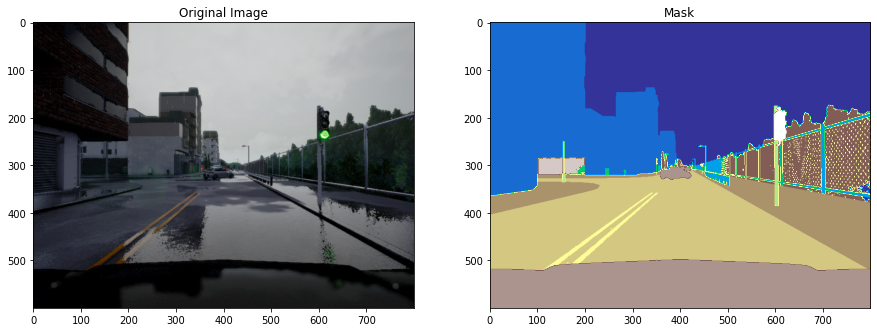

In [9]:
import imageio

n = 150 # you can chose any index 
img  = imageio.imread(X_train[n])
print(img.shape)
mask = imageio.imread(y_train[n])
print(mask.shape)

mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask, cmap='terrain')
arr[1].set_title('Mask')

In [10]:
train_image_list_dataset = tf.data.Dataset.list_files(X_train, shuffle=False)
train_mask_list_dataset = tf.data.Dataset.list_files(y_train, shuffle=False)
val_image_list_dataset = tf.data.Dataset.list_files(X_val, shuffle=False)
val_mask_list_dataset = tf.data.Dataset.list_files(y_val, shuffle=False)
test_image_list_dataset = tf.data.Dataset.list_files(X_test, shuffle=False)
test_mask_list_dataset = tf.data.Dataset.list_files(y_test, shuffle=False)

train_images_filenames = tf.constant(X_train)
train_masks_filenames = tf.constant(y_train)
val_images_filenames = tf.constant(X_val)
val_masks_filenames = tf.constant(y_val)
test_images_filenames = tf.constant(X_test)
test_masks_filenames = tf.constant(y_test)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_filenames, train_masks_filenames))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_filenames, val_masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_filenames, test_masks_filenames))

for image, mask in train_dataset.take(2) : 
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Project4/dataC/CameraRGB/F6-65.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Project4/dataC/CameraSeg/F6-65.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Project4/dataA/CameraRGB/07_00_231.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Project4/dataA/CameraSeg/07_00_231.png', shape=(), dtype=string)


In [12]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)            # 정규화 작업.
    img = tf.image.convert_image_dtype(img,tf.float32) 
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)          # 정규화 작업.
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img, mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96, 128))
    input_mask = tf.image.resize(mask,(96, 128))
    
    return input_image, input_mask

In [13]:
train_image_ds = train_dataset.map(process_path)
val_image_ds = val_dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)         # 이미지 정규화


train_processed_image_ds = train_image_ds.map(preprocess)
val_processed_image_ds = val_image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)  # 리사이징

In [14]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters,                                                    # CNN Layer
                  kernel_size = 3,                                              # Kernel Size = 3
                  activation='relu',                                            # 활성함수 ReLU
                  padding='same',                                               # 패딩 사이즈는 같게
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)  # He 초기화 사용

    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv) 
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection



def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(                                                       # Upsampling
                 n_filters,  
                 kernel_size = 3,                                               # Kernel Size = 3
                 strides=(2,2),                                                 # Kernel 은 2칸씩
                 padding='same')(expansive_input)                               # 패딩 크기는 같게
    
    merge = concatenate([up, contractive_input], axis=3)                        # skip connection과 concatenate
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv


In [16]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=13):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [17]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model(input_size=(img_height, img_width, num_channels))

In [18]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [19]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
TRAIN_LENGTH = len(X_train)
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 1000
BATCH_SIZE = 32

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = len(X_val)//BATCH_SIZE//VAL_SUBSPLITS

train_processed_image_ds.batch(BATCH_SIZE)

train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_processed_image_ds.batch(BATCH_SIZE)
test_dataset = test_processed_image_ds.batch(BATCH_SIZE)

In [21]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [24]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    """
    에포크마다 보여줄 수 있되
    매 에포크마다 이전 결과가 지워지도록 하는 Callback 클래스 입니다.
    """
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

In [25]:
model_history = unet.fit(train_dataset, epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=val_dataset)

Epoch 1/100
125/125 [==============================] - 2183s 13s/step - loss: 1.1495 - accuracy: 0.6198 - val_loss: 0.6460 - val_accuracy: 0.7949
Epoch 2/100
125/125 [==============================] - 39s 313ms/step - loss: 0.5268 - accuracy: 0.8341 - val_loss: 0.4360 - val_accuracy: 0.8683
Epoch 3/100
125/125 [==============================] - 40s 319ms/step - loss: 0.3819 - accuracy: 0.8835 - val_loss: 0.3485 - val_accuracy: 0.8917
Epoch 4/100
125/125 [==============================] - 38s 306ms/step - loss: 0.3218 - accuracy: 0.8993 - val_loss: 0.3126 - val_accuracy: 0.8999
Epoch 5/100
125/125 [==============================] - 39s 312ms/step - loss: 0.2901 - accuracy: 0.9076 - val_loss: 0.2825 - val_accuracy: 0.9083
Epoch 6/100
125/125 [==============================] - 38s 307ms/step - loss: 0.2674 - accuracy: 0.9134 - val_loss: 0.2658 - val_accuracy: 0.9133
Epoch 7/100
125/125 [==============================] - 38s 305ms/step - loss: 0.2490 - accuracy: 0.9179 - val_loss: 0.2436 -

Text(0.5, 0, 'Epochs')

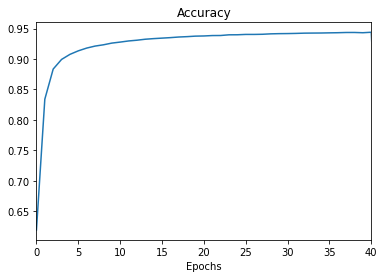

In [32]:
plt.plot(model_history.history["accuracy"])
plt.xlim([0, 40])
plt.title('Accuracy')
plt.xlabel('Epochs')

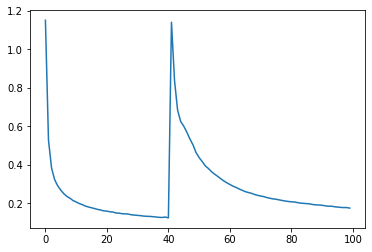

In [27]:
plt.plot(model_history.history["loss"])

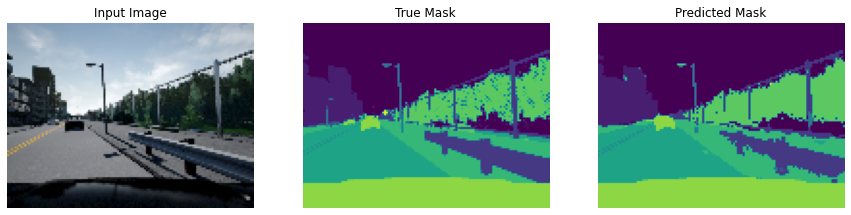

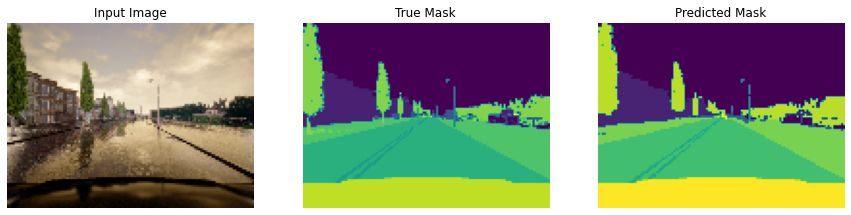

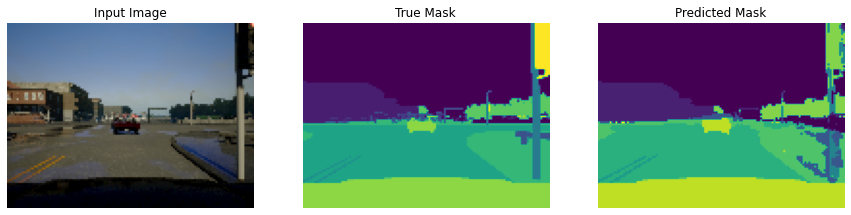

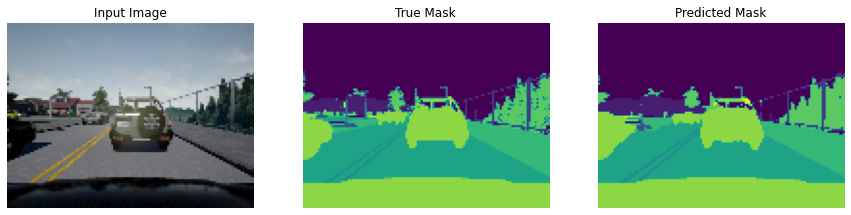

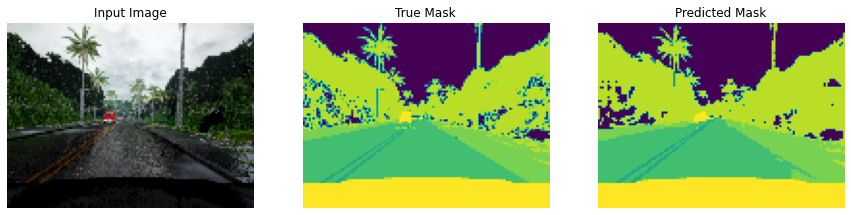

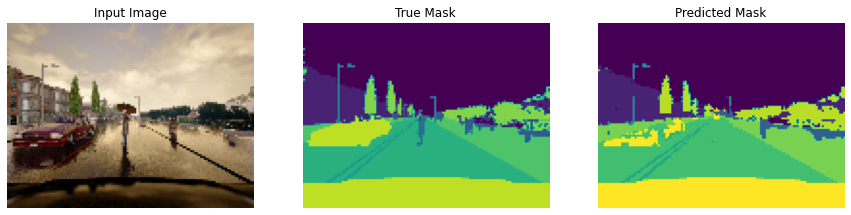

In [28]:
show_predictions(test_dataset, 6)